https://www.kaggle.com/datasets/sergeynesteruk/apple-rotting-segmentation-problem-in-the-wild

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
#1- Import Libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
#1- Import Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
#2- Define Paths:

num_classes = 3 # after grouping 

folder_train = 'max_data/train/'
folder_test = 'max_data/test/'
folder_background = 'Sk_background/'
folder_wild = 'wild/'

In [5]:
#3- Data Analysis & Split Dataset
# image in folder train .jpg and mask .png 
image_names_path = sorted(glob.glob(os.path.join(folder_train, "*.jpg")))
mask_names_path = sorted(glob.glob(os.path.join(folder_train, "*.png")))
image_background = sorted(glob.glob(os.path.join(folder_background, "*.JPG")))

In [6]:
image_names = [x.split('/')[-1] for x in image_names_path]
mask_names = [x.split('/')[-1] for x in mask_names_path]

In [7]:
# only the image array will be used and 'obj' will be replaced by 'mask'. 
temp_array = [string.replace('obj', 'msk') for string in image_names]
modified_array = [string.replace('jpg', 'png') for string in temp_array]
# check if array are the same
modified_array == mask_names # if two lists have the same elements in the same order
# set(mask_names) == set(modified_array) # if two lists have the same elements, regardless of their order 

True

In [8]:
# image in folder test .jpg and mask .png 
test_image_names_path = sorted(glob.glob(os.path.join(folder_test, "*.jpg")))
test_mask_names_path = sorted(glob.glob(os.path.join(folder_test, "*.png")))

test_image_names = [x.split('/')[-1] for x in test_image_names_path]
test_mask_names = [x.split('/')[-1] for x in test_mask_names_path]

In [9]:
# only the image array will be used and 'obj' will be replaced by 'mask'. 
temp_array = [string.replace('obj', 'msk') for string in test_image_names]
modified_array = [string.replace('jpg', 'png') for string in temp_array]
# check if array are the same
modified_array == test_mask_names # if two lists have the same elements in the same order
# set(mask_names) == set(modified_array) # if two lists have the same elements, regardless of their order

True

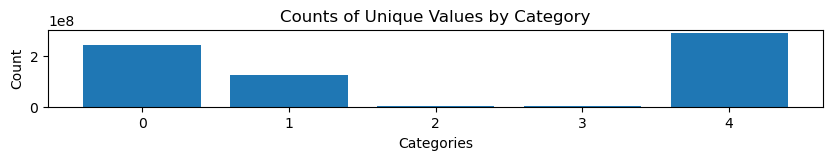

In [10]:
# create a bar chart of the value_counts dictionary
value_counts = {0: 243684720, 4: 290920946, 1: 126954028, 2: 1560020, 3: 1509608}
fig = plt.figure(figsize=(10, 1))
plt.bar(value_counts.keys(), value_counts.values())

# set the axis labels and title
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Counts of Unique Values by Category")

# show the plot
plt.show()

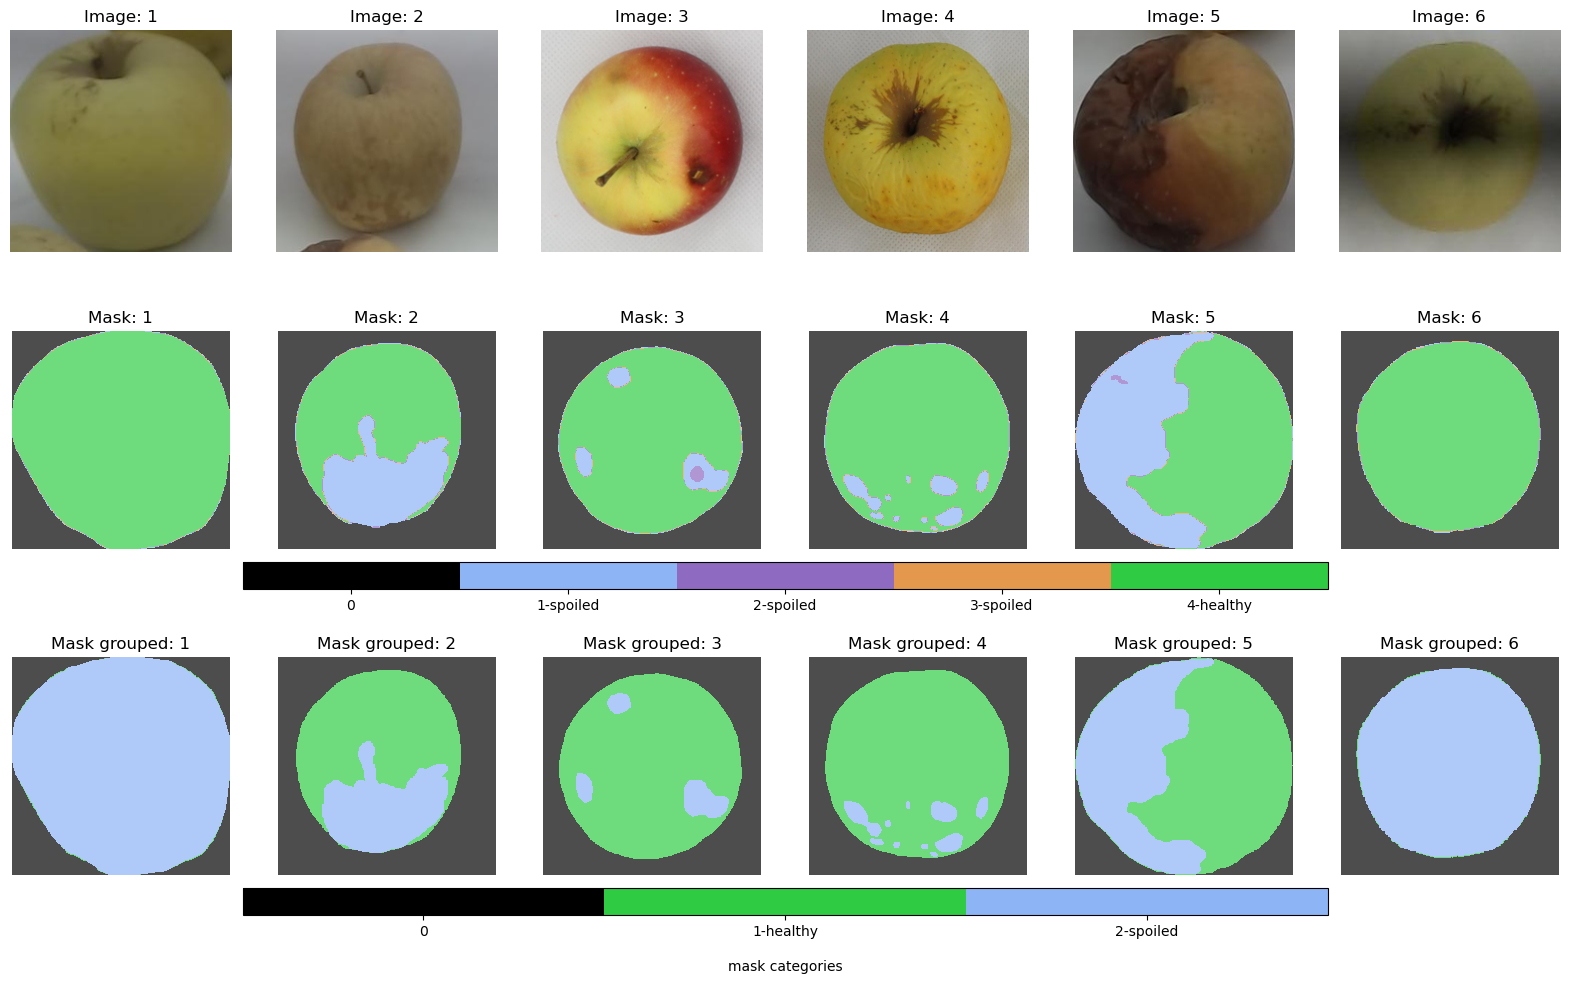

In [11]:
# mask categories
import matplotlib.colors as mcolors

# Define five custom colors
colors = ['#000000', '#8DB4F5', '#8E6BC1', '#E4984D', '#2FCC43']
colors2 = ['#000000', '#2FCC43', '#8DB4F5']
# Create a colormap from the custom colors
cmap = mcolors.ListedColormap(colors)
cmap2 = mcolors.ListedColormap(colors2)

# Create a figure 
fig, axs = plt.subplots(3, 6, figsize=(20, 12))

# Loop over the array list and plot each array
for i, img_selected in enumerate(random.sample(image_names, 6)):
    mask_selected = img_selected.replace('obj', 'msk').replace('jpg', 'png')
    row_index = i // 6
    col_index = i % 6
    
    # Plot image and mask in first and second row respectively
    if row_index == 0:
        axs[0, col_index].imshow(Image.open(folder_train + img_selected).resize((224,224)))
        axs[0, col_index].set_title('Image: '+str(i+1))
        axs[0, col_index].axis('off') 

        axs[1, col_index].imshow(Image.open(folder_train + mask_selected).resize((224,224)), alpha=0.7, cmap=cmap)
        axs[1, col_index].set_title('Mask: '+str(i+1))
        axs[1, col_index].axis('off')
        
        mask_grouped=Image.open(folder_train + mask_selected)
        # PIL to array
        mask_grouped = np.array(mask_grouped) 
        # group categories  
        # 0 - background      <-- 0 
        # 1 - healthy apple   <-- 4 
        # 2 - spoiled apple   <-- 1,2,3
        mask_grouped[np.where((mask_grouped == 1) | (mask_grouped == 2) | (mask_grouped == 3))] = 2
        mask_grouped[np.where(mask_grouped == 4)] = 1
        # mask array to PIL
        mask_grouped = Image.fromarray(mask_grouped.astype('uint8'), 'L')
        axs[2, col_index].imshow(mask_grouped.resize((224,224)), alpha=0.7, cmap=cmap2)
        axs[2, col_index].set_title('Mask grouped: '+str(i+1))
        axs[2, col_index].axis('off')

# Add color bar below the second row
norm = plt.Normalize(0, 5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs[1, :], orientation='horizontal', pad=0.05, ticks=[0, 1, 2, 3, 4], shrink=0.7, aspect=40)
cbar.ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
cbar.ax.set_xticklabels(['0', '1-spoiled', '2-spoiled', '3-spoiled', '4-healthy'])
#cbar.set_label('mask categories', labelpad=14)

# Create a second ScalarMappable object with a different normalization range
norm2 = plt.Normalize(0, 3)
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
# Add a color bar below the third row
cbar2 = plt.colorbar(sm2, ax=axs[2, :], orientation='horizontal', pad=0.05, ticks=[0, 1, 2], shrink=0.7, aspect=40)
cbar2.ax.set_xticks([0.5, 1.5, 2.5])
cbar2.ax.set_xticklabels(['0', '1-healthy', '2-spoiled'])
cbar2.set_label('mask categories', labelpad=15)

plt.show()


In [79]:
def make_wild_apples(folder, image_name_list):
    size_background = (512,512)
    size_apples = (150,150)
    
    # image background of zeros
    img_background_selected = Image.fromarray(np.zeros((size_background[0],size_background[1],3)).astype('uint8'), 'RGB')
    # copy
    image_apples_backgroud = img_background_selected.copy()
    # image backgound for whole mask
    image_apples_backgroud_mask = Image.fromarray(np.zeros(size_background).astype('uint8'), 'L')

    for img_selected in image_name_list:
        # open mask
        mask_selected = img_selected.replace('obj', 'msk').replace('jpg', 'png')
        # open image 
        img_selected = Image.open(folder + img_selected).resize(size_apples)  
    
        # mask whole apple with mask_selected
        mask_apples=np.array(Image.open(folder + mask_selected).resize(size_apples)) 
        mask_apples[np.where(mask_apples > 0)] = 1
        mask_apples = np.expand_dims(mask_apples, axis=2)    
        mask_apples_255 = np.zeros(mask_apples.shape, dtype=np.uint8)
        mask_apples_255[np.where(mask_apples == 1)] = 255

        # mask grouped class of mask_selected
        mask_grouped=np.array(Image.open(folder + mask_selected).resize(size_apples))
        mask_grouped[np.where((mask_grouped == 1) | (mask_grouped == 2) | (mask_grouped == 3))] = 2
        mask_grouped[np.where(mask_grouped == 4)] = 1
        mask_grouped = Image.fromarray(mask_grouped.astype('uint8'), 'L')

        # image & backgound
        img_selected_array = np.array(img_selected)
        image_mask_apples = img_selected_array * mask_apples
        image_mask_apples = Image.fromarray(image_mask_apples)
        
        # random insert
        random_paste = list(np.random.randint(10,size_background[1]-10, size=(1, 2), dtype=int)[0])
 
        # PIL paste
        image_apples_backgroud.paste(image_mask_apples, random_paste, mask=Image.fromarray(mask_apples_255[:,:,0]))    
        image_apples_backgroud_mask.paste(mask_grouped, random_paste, mask=Image.fromarray(mask_apples_255[:,:,0]))

    return image_apples_backgroud, image_apples_backgroud_mask    

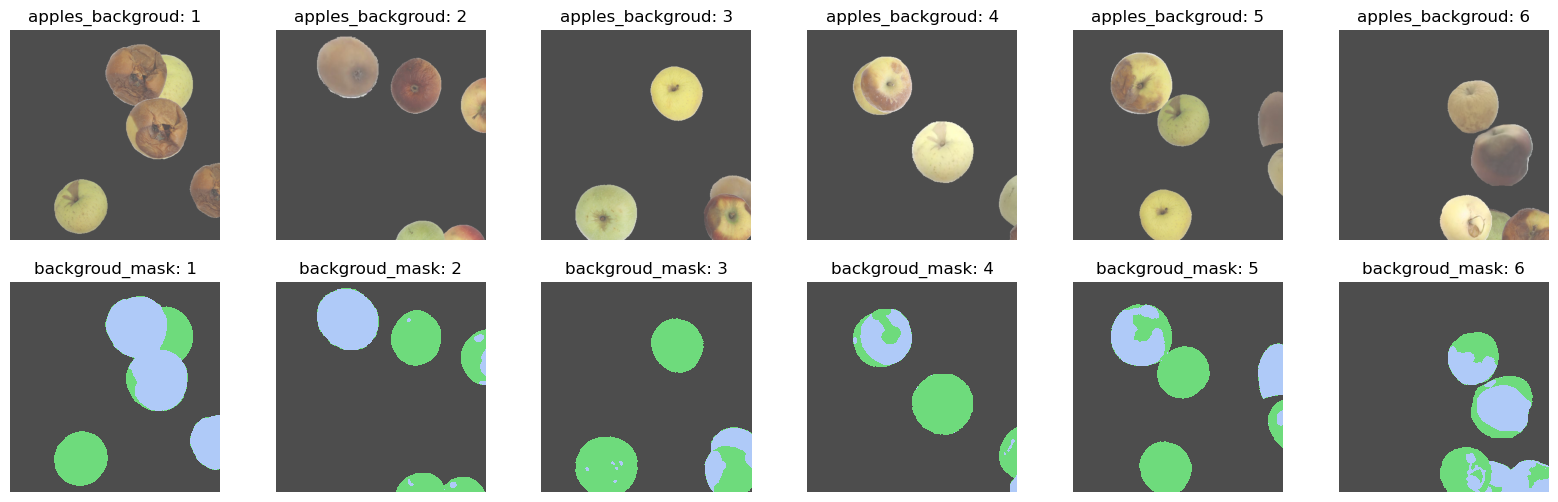

In [81]:
# Create a figure 
fig, axs = plt.subplots(2, 6, figsize=(20, 6))
# loop in number of plots
for i in range (6):
    #row_index = i // 6
    col_index = i % 6
    
    # get images list
    image_name_list = random.sample(image_names, 5) # get images list
    # get_as_wild_apples
    image_apples_backgroud, image_apples_backgroud_mask = make_wild_apples(folder_train, image_name_list)
    
    # plots
    axs[0,col_index].imshow(image_apples_backgroud, alpha=0.7)
    axs[0,col_index].set_title('apples_backgroud: '+str(i+1))
    axs[0,col_index].axis('off')
    
    axs[1,col_index].imshow(image_apples_backgroud_mask, alpha=0.7, cmap=cmap2)
    axs[1,col_index].set_title('backgroud_mask: '+str(i+1))
    axs[1,col_index].axis('off')
    
plt.show()

In [87]:
#4- Define custom Datasets, data augmentation, Data Loaders
#num_classes for one hot encode
class CustomDataset(Dataset):
    def __init__(self, folder, image_filenames, transforms=None):
        self.folder = folder
        self.image_filenames = image_filenames
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_filenames)
  
    def __getitem__(self, idx):
        
        seed = np.random.randint(2023)
        random.seed(seed)
        torch.manual_seed(seed)
        
        batch_size_random = int(np.random.randint(3,7, size=1, dtype=int)[0])
        image_name_list = random.sample(self.image_filenames, batch_size_random)
        
        image, mask = make_wild_apples(self.folder, image_name_list)
    
                 
        if self.transforms is not None:
            seed = np.random.randint(2023)
            
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transforms(image)
            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transforms(mask)
            
            mask = np.eye(num_classes)[mask].astype(np.float32) # one hot encoder

            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
            
            mask = transforms.ToTensor()(mask)
            
            return image, mask    

In [88]:
# Define data augmentation

image_size = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-90,90)),
     ]) #transforms.ToTensor()

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    ]) # transforms.ToTensor() 

In [89]:
# Split Dataset
train_filenames, val_filenames = train_test_split(image_names, test_size=0.2, random_state=42, shuffle=True)

In [90]:
# Print number of samples in each set
print(f'Total Images: {len(image_names)}')
print(f'Total Masks: {len(mask_names)}')
print(f'Training samples: {len(train_filenames)}')
print(f'Validation samples: {len(val_filenames)}')
print(f'Testing samples: {len(test_image_names)}')

Total Images: 2958
Total Masks: 2958
Training samples: 2366
Validation samples: 592
Testing samples: 1276


In [95]:
# Create datasets and data loaders
train_dataset = CustomDataset(folder_train, train_filenames, train_transforms)
val_dataset = CustomDataset(folder_train, val_filenames, val_transforms)
test_dataset = CustomDataset(folder_test, test_image_names, val_transforms)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

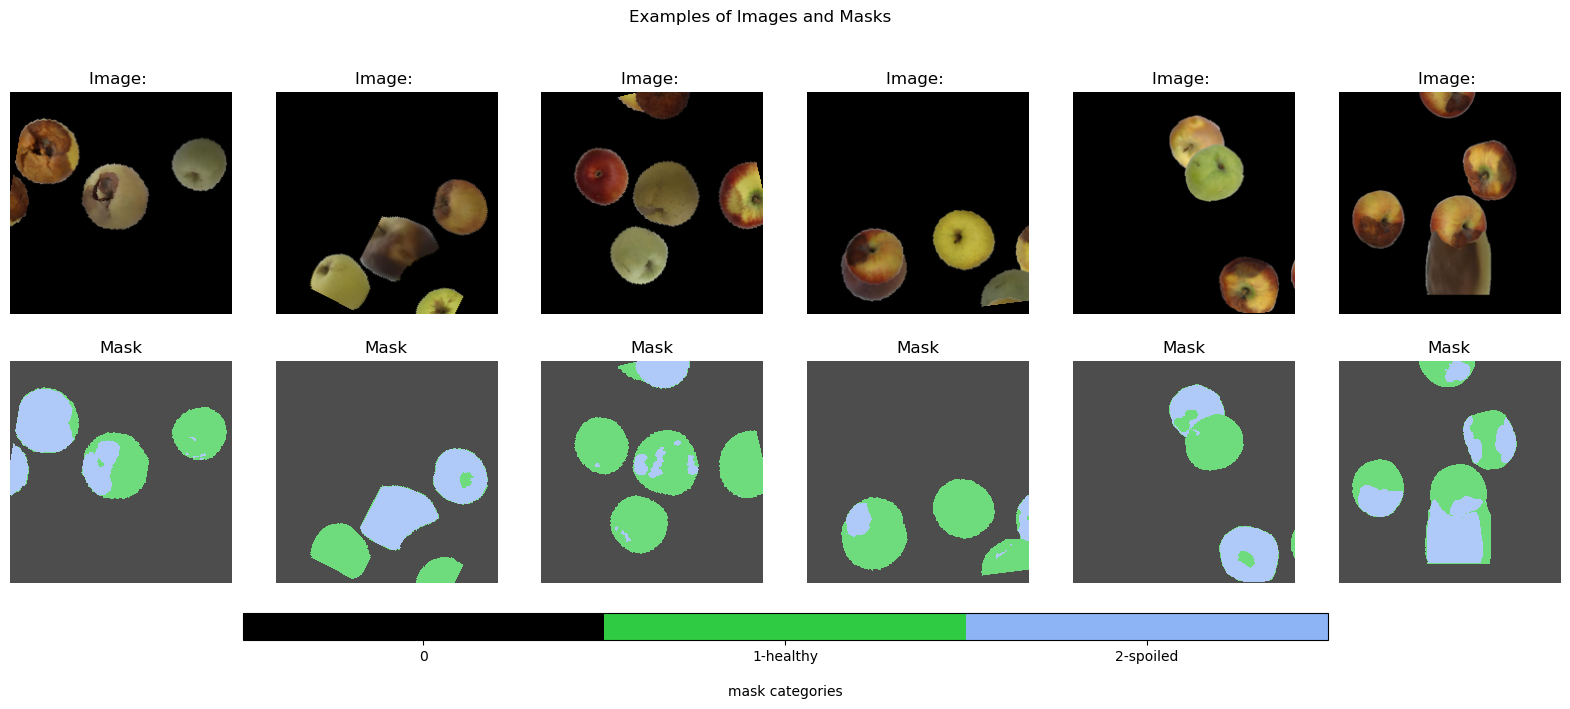

In [96]:
#5- Plot examples of image and mask pairs

images, masks = next(iter(train_loader))

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def plot_image_mask_pairs(images, masks, num_pairs=6):
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(20, 8))
    fig.suptitle('Examples of Images and Masks')

    for i in range(num_pairs):
        # Plot image
        axs[0, i].imshow(np.clip(images[i].permute(1,2,0).numpy()* std + mean, 0, 255))
        axs[0, i].set_title('Image: ')
        axs[0, i].axis('off')    
        # Plot mask
        axs[1, i].imshow(torch.argmax(masks[i], dim=0), alpha=0.7, cmap=cmap2)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')
        
    # Add color bar below the second row
    norm = plt.Normalize(0, 3)
    sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[:, :], orientation='horizontal', pad=0.05, ticks=[0, 1, 2], shrink=0.7, aspect=40)
    cbar.ax.set_xticks([0.5, 1.5, 2.5])
    cbar.ax.set_xticklabels(['0', '1-healthy', '2-spoiled'])
    cbar.set_label('mask categories', labelpad=15)
   
    plt.show()

plot_image_mask_pairs(images, masks)

In [97]:
images[0].type(), masks[0].type()

('torch.FloatTensor', 'torch.FloatTensor')

In [98]:
images[0].size(), masks[0].size()

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [62]:
#6- Define Model
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch --quiet
import segmentation_models_pytorch as smp
import time
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=num_classes, activation=None, 
                 encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model = model.to(device)

In [63]:
#7- Define Loss Function, Optimizer, scheduler and Early Stopping class:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [64]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, mode='min'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        if self.mode == 'min':
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == 'min':
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        torch.save({'epoch_score': epoch_score, 'model_state_dict': model.state_dict()}, model_path)


In [65]:
#8- Define metrics

def iou_score(outputs, targets, smooth=1e-6):
    intersection = (outputs & targets).sum()
    union = (outputs | targets).sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou

def pixel_accuracy(outputs, targets):
    correct = (outputs == targets).sum()
    total = targets.numel()
    accuracy = correct / total
    return accuracy

def mean_accuracy(outputs, targets):
    class_accs = []
    for c in range(23):
        class_pixels = (targets == c).sum()
        correct = ((outputs == c) & (targets == c)).sum()
        if class_pixels == 0:
            class_acc = 0
        else:
            class_acc = correct / class_pixels
        class_accs.append(class_acc)
    mean_acc = torch.tensor(class_accs).cpu().numpy().mean()
    return mean_acc

def f1_score(outputs, targets, smooth=1e-6):
    tp = ((outputs == 1) & (targets == 1)).sum()
    fp = ((outputs == 1) & (targets == 0)).sum()
    fn = ((outputs == 0) & (targets == 1)).sum()
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1

def dice_score(outputs, targets, smooth=1e-6):
    intersection = (outputs & targets).sum()
    dice = (2 * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)
    return dice


In [68]:
#9- Define and execute Training Loop and Validation loop

class TrainerClass:
    def __init__(self, model, train_loader=None, val_loader=None, optimizer=None, criterion=None, scheduler=None, num_epochs=None, early_stopping_patience=None):
        self.num_epochs = num_epochs
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.early_stopping = EarlyStopping(patience=early_stopping_patience)
        
        self.history = {
            'train_loss': [], 
                'train_iou': [], 'train_pixel_acc': [], 'train_mean_acc': [], 'train_f1': [], 'train_dice': [],
            'val_loss': [],
                 'val_iou': [], 'val_pixel_acc': [], 'val_mean_acc': [], 'val_f1': [], 'val_dice': [] }

    def run_one_epoch(self, loader, is_training):
        if is_training:
            self.model.train()
        else:
            self.model.eval()

        epoch_metrics = { 'loss': 0, 'iou': 0, 'pixel_acc': 0, 'mean_acc': 0,  'f1': 0, 'dice': 0 }

        with torch.set_grad_enabled(is_training):
            for inputs, targets in tqdm(loader, leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = self.model(inputs)
                #print(outputs.shape)
                #print(targets.shape)
                loss = self.criterion(outputs, targets)

                if is_training:
                    # Backward pass and optimization
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                pred_masks = F.softmax(outputs, dim=1) ##
                pred_masks = torch.argmax(pred_masks, dim=1)
                pred_masks = pred_masks.unsqueeze(1).long()
                pred_masks = pred_masks.long()
                targets = targets.long()
                
                # Compute the metrics
                epoch_metrics['loss'] += loss.item() * inputs.size(0)
                epoch_metrics['iou'] += iou_score(pred_masks, targets) * inputs.size(0)
                epoch_metrics['pixel_acc'] += pixel_accuracy(pred_masks, targets) * inputs.size(0)
                epoch_metrics['mean_acc'] += mean_accuracy(pred_masks, targets) * inputs.size(0)
                epoch_metrics['f1'] += f1_score(pred_masks, targets) * inputs.size(0)
                epoch_metrics['dice'] += dice_score(pred_masks, targets) * inputs.size(0)

        epoch_metrics = {k: v / len(loader.dataset) for k, v in epoch_metrics.items()}

        if is_training:
            prefix = 'train'
        else:
            prefix = 'val'

        for k, v in epoch_metrics.items():
            self.history[f'{prefix}_{k}'].append(v)

        return epoch_metrics['loss'], epoch_metrics['iou'], epoch_metrics['pixel_acc'], epoch_metrics['mean_acc'], epoch_metrics['f1'], epoch_metrics['dice']

    def train_and_validate(self):
        for epoch in range(self.num_epochs):

            train_loss, train_iou, train_pixel_acc, train_mean_acc, train_f1, train_dice = self.run_one_epoch(self.train_loader, is_training=True)
            val_loss, val_iou, val_pixel_acc, val_mean_acc, val_f1, val_dice = self.run_one_epoch(self.val_loader, is_training=False)

            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Pixel Acc: {train_pixel_acc:.4f}, Train Mean Acc: {train_mean_acc:.4f}, Train F1: {train_f1:.4f}, Train Dice: {train_dice:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}, Val Mean Acc: {val_mean_acc:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}')

            self.early_stopping(val_loss, self.model, 'model_checkpoint_V6.pth')

            if self.scheduler:
                self.scheduler.step(val_loss)

            if self.early_stopping.early_stop:
                print('Early stopping')
                break

        return self.history


In [69]:
trainer = TrainerClass(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15, early_stopping_patience=10)
history = trainer.train_and_validate()

Epoch 1/15
Train Loss: 0.1737, Train IoU: 0.0736, Train Pixel Acc: 0.5793, Train Mean Acc: 0.0402, Train F1: 0.1806, Train Dice: 0.1850
Val Loss: 0.0662, Val IoU: 0.0714, Val Pixel Acc: 0.5885, Val Mean Acc: 0.0408, Val F1: 0.1768, Val Dice: 0.1836


Epoch 2/15
Train Loss: 0.0520, Train IoU: 0.0751, Train Pixel Acc: 0.5957, Train Mean Acc: 0.0413, Train F1: 0.1767, Train Dice: 0.1887
Val Loss: 0.0496, Val IoU: 0.0830, Val Pixel Acc: 0.5940, Val Mean Acc: 0.0415, Val F1: 0.1897, Val Dice: 0.2082


Epoch 3/15
Train Loss: 0.0441, Train IoU: 0.0754, Train Pixel Acc: 0.5969, Train Mean Acc: 0.0414, Train F1: 0.1759, Train Dice: 0.1886
Val Loss: 0.0416, Val IoU: 0.0742, Val Pixel Acc: 0.5888, Val Mean Acc: 0.0410, Val F1: 0.1811, Val Dice: 0.1904


Epoch 4/15
Train Loss: 0.0409, Train IoU: 0.0743, Train Pixel Acc: 0.5966, Train Mean Acc: 0.0414, Train F1: 0.1747, Train Dice: 0.1864
Val Loss: 0.0405, Val IoU: 0.0790, Val Pixel Acc: 0.5918, Val Mean Acc: 0.0413, Val F1: 0.1858, Val Dice: 0.2001


Epoch 5/15
Train Loss: 0.0366, Train IoU: 0.0752, Train Pixel Acc: 0.5958, Train Mean Acc: 0.0413, Train F1: 0.1767, Train Dice: 0.1888
Val Loss: 0.0358, Val IoU: 0.0765, Val Pixel Acc: 0.5898, Val Mean Acc: 0.0411, Val F1: 0.1839, Val Dice: 0.1953


Epoch 6/15
Train Loss: 0.0351, Train IoU: 0.0749, Train Pixel Acc: 0.5959, Train Mean Acc: 0.0413, Train F1: 0.1762, Train Dice: 0.1881
Val Loss: 0.0354, Val IoU: 0.0737, Val Pixel Acc: 0.5900, Val Mean Acc: 0.0410, Val F1: 0.1793, Val Dice: 0.1885


Epoch 7/15
Train Loss: 0.0325, Train IoU: 0.0751, Train Pixel Acc: 0.5962, Train Mean Acc: 0.0414, Train F1: 0.1763, Train Dice: 0.1885
Val Loss: 0.0342, Val IoU: 0.0797, Val Pixel Acc: 0.5904, Val Mean Acc: 0.0412, Val F1: 0.1879, Val Dice: 0.2023


Epoch 8/15
Train Loss: 0.0322, Train IoU: 0.0741, Train Pixel Acc: 0.5956, Train Mean Acc: 0.0413, Train F1: 0.1752, Train Dice: 0.1864
Val Loss: 0.0586, Val IoU: 0.0820, Val Pixel Acc: 0.5921, Val Mean Acc: 0.0414, Val F1: 0.1901, Val Dice: 0.2070


Epoch 9/15
Train Loss: 0.0302, Train IoU: 0.0739, Train Pixel Acc: 0.5955, Train Mean Acc: 0.0413, Train F1: 0.1751, Train Dice: 0.1861
Val Loss: 0.0320, Val IoU: 0.0775, Val Pixel Acc: 0.5900, Val Mean Acc: 0.0411, Val F1: 0.1850, Val Dice: 0.1973


Epoch 10/15
Train Loss: 0.0305, Train IoU: 0.0735, Train Pixel Acc: 0.5958, Train Mean Acc: 0.0413, Train F1: 0.1740, Train Dice: 0.1848
Val Loss: 0.0335, Val IoU: 0.0754, Val Pixel Acc: 0.5893, Val Mean Acc: 0.0410, Val F1: 0.1826, Val Dice: 0.1929


Epoch 11/15
Train Loss: 0.0295, Train IoU: 0.0756, Train Pixel Acc: 0.5948, Train Mean Acc: 0.0413, Train F1: 0.1782, Train Dice: 0.1903
Val Loss: 2.4193, Val IoU: 0.2274, Val Pixel Acc: 0.4396, Val Mean Acc: 0.0409, Val F1: 0.4282, Val Dice: 0.6706


Epoch 12/15
Train Loss: 0.0308, Train IoU: 0.0745, Train Pixel Acc: 0.5959, Train Mean Acc: 0.0413, Train F1: 0.1755, Train Dice: 0.1872
Val Loss: 0.0311, Val IoU: 0.0733, Val Pixel Acc: 0.5887, Val Mean Acc: 0.0409, Val F1: 0.1798, Val Dice: 0.1882


Epoch 13/15
Train Loss: 0.0279, Train IoU: 0.0743, Train Pixel Acc: 0.5959, Train Mean Acc: 0.0413, Train F1: 0.1753, Train Dice: 0.1867
Val Loss: 0.0328, Val IoU: 0.0798, Val Pixel Acc: 0.5909, Val Mean Acc: 0.0412, Val F1: 0.1878, Val Dice: 0.2025


Epoch 14/15
Train Loss: 0.0282, Train IoU: 0.0733, Train Pixel Acc: 0.5965, Train Mean Acc: 0.0413, Train F1: 0.1732, Train Dice: 0.1841
Val Loss: 0.0315, Val IoU: 0.0804, Val Pixel Acc: 0.5904, Val Mean Acc: 0.0412, Val F1: 0.1890, Val Dice: 0.2041


Epoch 15/15
Train Loss: 0.0281, Train IoU: 0.0743, Train Pixel Acc: 0.5963, Train Mean Acc: 0.0413, Train F1: 0.1749, Train Dice: 0.1866
Val Loss: 0.0301, Val IoU: 0.0801, Val Pixel Acc: 0.5905, Val Mean Acc: 0.0412, Val F1: 0.1887, Val Dice: 0.2034


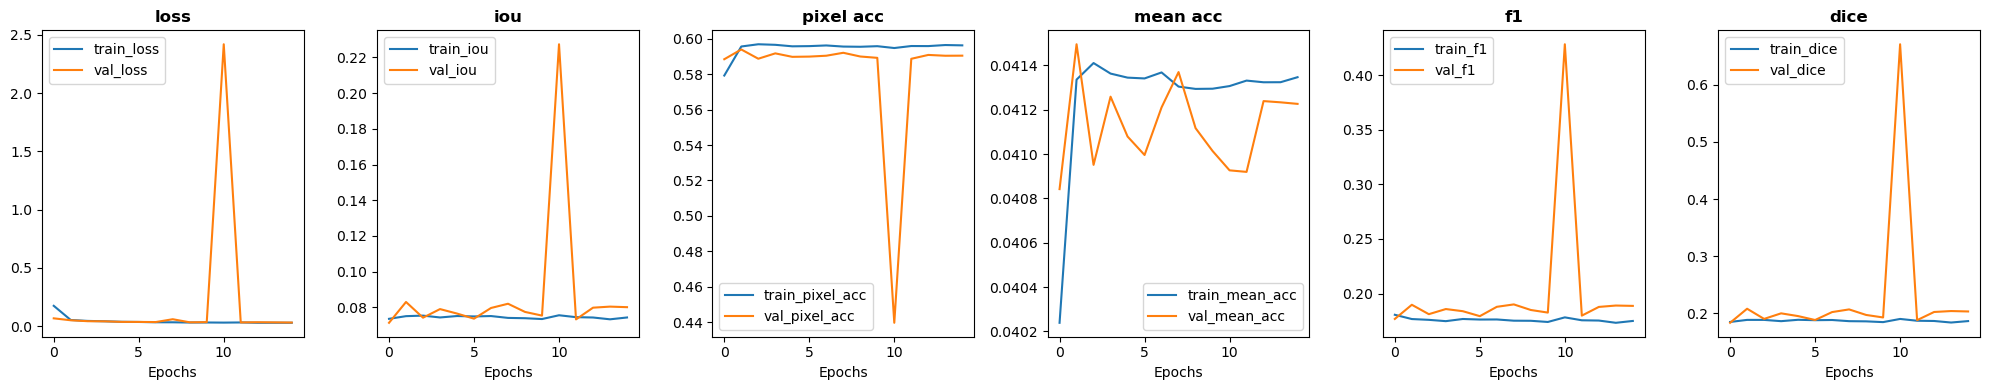

In [70]:
#10-
def plot_history(history):

    fig, axs = plt.subplots(1, 6, figsize=(20, 4))

    for i, (key, values) in enumerate(history.items()):
        col = i % 6
        axs[col].plot(values, label=key)
        axs[col].set_title(' '.join(key.split('_')[1:]), fontweight ='bold')
        axs[col].set_xlabel("Epochs")
        axs[col].legend()

    plt.tight_layout()
    plt.show()
    
plot_history(history)

In [99]:
#11- Evaluate model on the test set
# Load the saved model
checkpoint = torch.load('model_checkpoint_V6.pth')
model.load_state_dict(checkpoint['model_state_dict'])

#trainer = TrainerClass(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=3, early_stopping_patience=5)

# Set the model to evaluation mode
model.eval()

# Test on the test_loader
test_loss, test_iou, test_pixel_acc, test_mean_acc, test_f1, test_dice = trainer.run_one_epoch(test_loader, is_training=False)
print(f'Test Loss: {test_loss:.4f}') 
print(f'Test IoU: {test_iou:.4f}') 
print(f'Test Pixel Acc: {test_pixel_acc:.4f}') 
print(f'Test Mean Acc: {test_mean_acc:.4f}') 
print(f'Test F1: {test_f1:.4f}')
print(f'Test Dice: {test_dice:.4f}')     

Test Loss: 0.0510
Test IoU: 0.0741
Test Pixel Acc: 0.5824
Test Mean Acc: 0.0406
Test F1: 0.1862
Test Dice: 0.1934


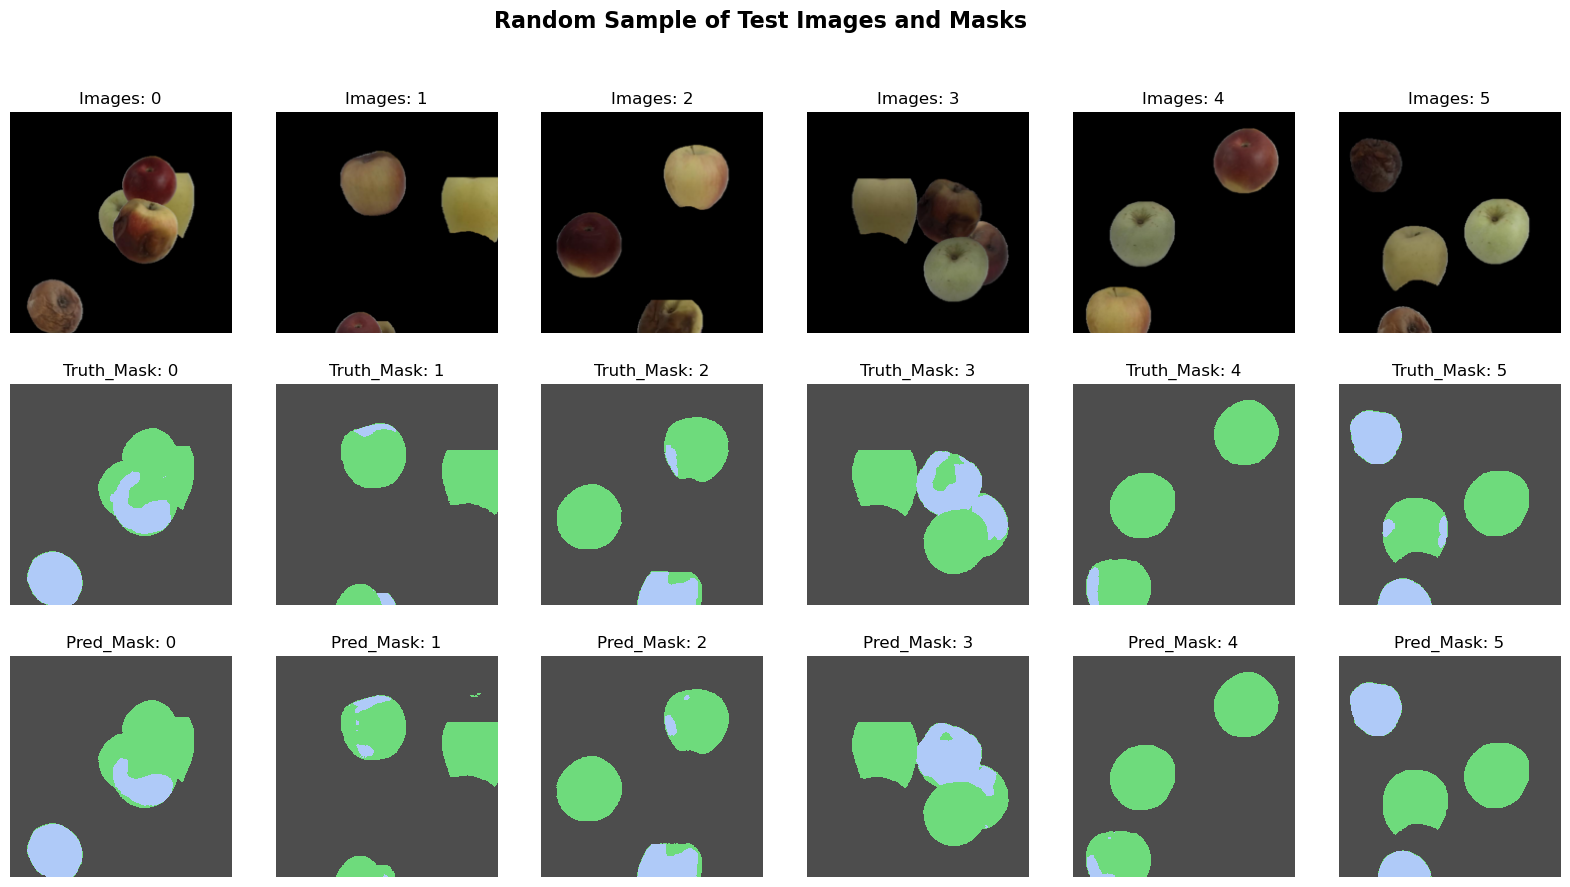

In [100]:
#12- Plot model evaluated on the test set
# Set the random seed for reproducibility
#random.seed(42)
# Load the saved model
checkpoint = torch.load('model_checkpoint_V6.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode
model.eval()

# Get a batch of sample images and masks
sample_size = 6
sample_indices = random.sample(range(len(test_loader.dataset)), sample_size)
sample_subset = data.Subset(test_loader.dataset, sample_indices)
sample_loader = data.DataLoader(sample_subset, batch_size=sample_size, shuffle=False)

with torch.no_grad():
    # Get a batch of images and masks from the dataloader
    images, masks = next(iter(sample_loader))
    images = images.to(device)
    masks = masks.to(device)
    output = model(images)
    pred_mask = F.softmax(output, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.squeeze().cpu().numpy()

    # Create a grid of subplots to plot the sample images and masks
    fig, axs = plt.subplots(3, sample_size, figsize=(20, 10))

    # Plot each image and mask in a separate subplot
    for i in range(sample_size):
        # Plot the image
        axs[0, i].imshow(np.clip(images[i].permute(1,2,0).numpy()* std + mean, 0, 255))
        axs[0, i].set_title('Images: '+str(i))
        axs[0, i].axis("off")

        # Plot the ground truth mask
        axs[1, i].imshow(torch.argmax(masks[i], dim=0), alpha=0.7, cmap=cmap2)
        axs[1, i].set_title('Truth_Mask: '+str(i))
        axs[1, i].axis("off")

        # Plot the predicted mask (assuming it's stored in a variable called mask_predicted)
        mask_predicted = model(images.to(device))
        axs[2, i].imshow(pred_mask[i], alpha=0.7, cmap=cmap2)
        axs[2, i].set_title('Pred_Mask: '+str(i))
        axs[2, i].axis("off")

    # Set the title of the plot
    fig.suptitle("Random Sample of Test Images and Masks", fontsize=16, fontweight='bold')

    # Show the plot
    plt.show()

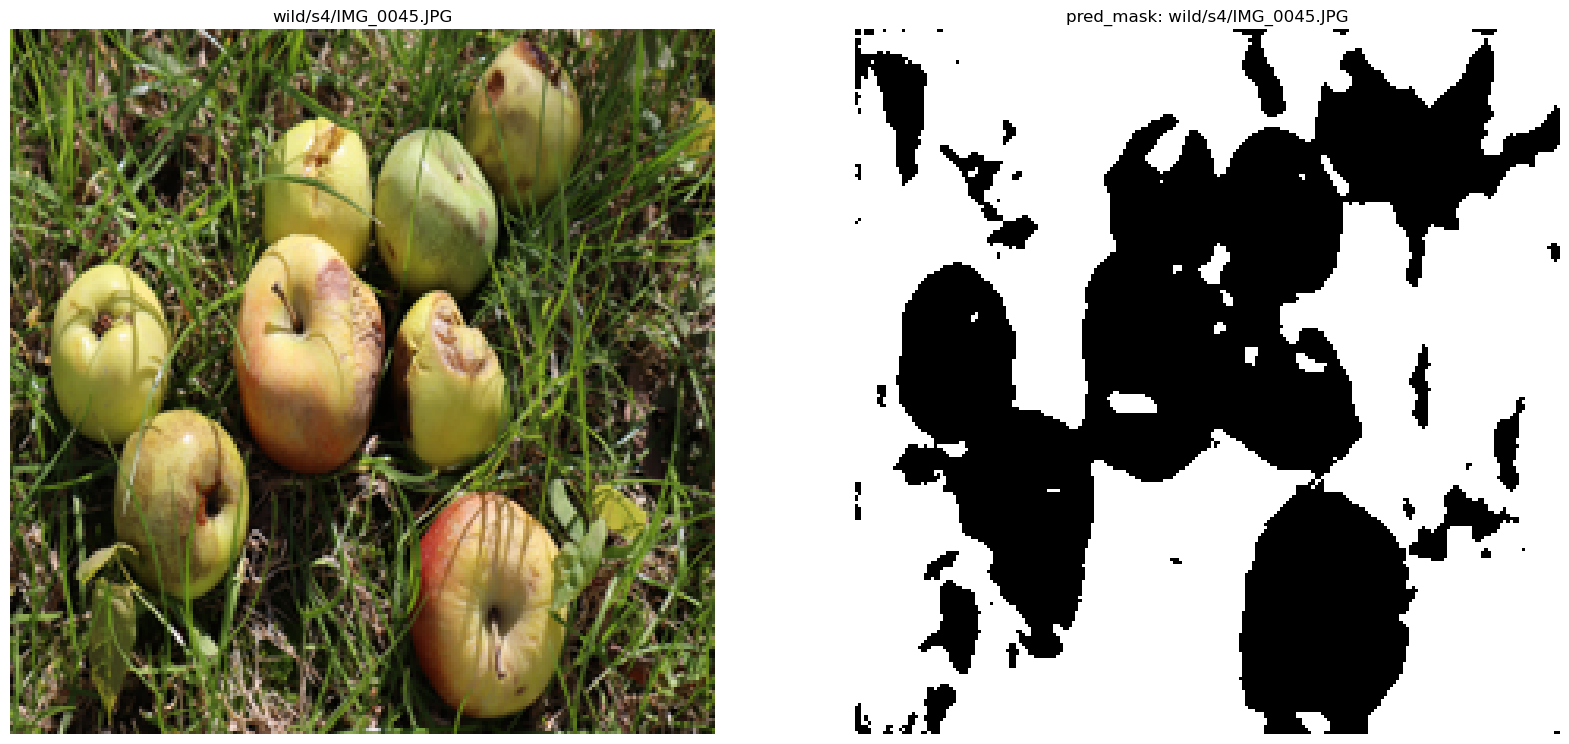

In [110]:
# 13- Use the saved model for inference on new images,

image_inference = folder_wild+'s4/IMG_0045.JPG'

# Load the saved model
checkpoint = torch.load('model_checkpoint_V6.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode
model.eval()
# Perform inference on any image
image = Image.open(image_inference).resize((224,224))
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor.to(device))
    pred_mask = F.softmax(output, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.squeeze().cpu().numpy()
    
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[0].set_title(image_inference)
axs[0].axis("off")

# Plot the pred mask
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('pred_mask: '+image_inference)
axs[1].axis("off")

plt.show()